In [1]:
# Import useful libraries
# For model training and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

# Data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, 

# Plottting lib
import matplotlib.pyplot as plt
import seaborn as sns

# Loading preprocessed data

In [2]:
# Read the data
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')

In [3]:
train_data.head()

,life_expectancy,adult_mortality,bmi,hiv_aids,income_comp_res,schooling
0,73.9,92.0,64.7,0.1,0.804,13.9
1,82.1,61.0,64.2,0.1,0.891,15.9
2,63.8,247.0,18.9,1.3,0.464,10.2
3,65.2,24.0,39.6,1.1,0.622,11.7
4,64.0,221.0,38.1,0.1,0.000,10.2


In [4]:
test_data.head()

,adult_mortality,bmi,hiv_aids,income_comp_res,schooling
0,268.0,18.1,0.1,0.470,9.9
1,291.0,14.2,0.1,0.396,7.9
2,316.0,12.6,0.1,0.340,5.9
3,88.0,55.1,0.1,0.738,13.3
4,91.0,53.5,0.1,0.721,12.2


In [5]:
# Separate target from features
y = train_data['life_expectancy']

features = train_data.drop(['life_expectancy'], axis=1)

In [6]:
features.describe()

,adult_mortality,bmi,hiv_aids,income_comp_res,schooling
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,184.694487,35.280938,2.100979,0.581410,11.201082
std,128.473544,19.412908,5.506793,0.200643,3.018143
min,1.000000,1.000000,0.100000,0.000000,0.000000
25%,94.000000,18.300000,0.100000,0.474000,9.700000
50%,163.000000,35.200000,0.100000,0.631000,11.700000
75%,254.000000,53.200000,1.500000,0.721000,13.100000
max,723.000000,82.800000,50.300000,0.919000,17.700000


In [7]:
# Hold out cross-validation
X_train, X_valid, y_train, y_valid = train_test_split(features.adult_mortality.values.reshape(-1, 1), y, random_state=0)

# Model training and evaluation

## OLS LinearRegression model

In [24]:
#Define the model (Univariate) 
#ols_model = make_pipeline(StandardScaler(with_mean=True), LinearRegression()) # Does not improve even by normalizing
ols_model = LinearRegression()

# Train the model
ols_model.fit(X_train, y_train)
preds_valid = ols_model.predict(X_valid)

In [25]:
print(r2_score(y_valid, preds_valid))

0.49418630381686135


In [26]:
# print MSE
print(mean_squared_error(y_valid, preds_valid, squared=False))

6.402646983147768


In [11]:
print("Slope : ", ols_model.coef_)
print("Intercept: ", ols_model.intercept_)

Slope :  [-0.0463056]
Intercept:  75.47058150201377


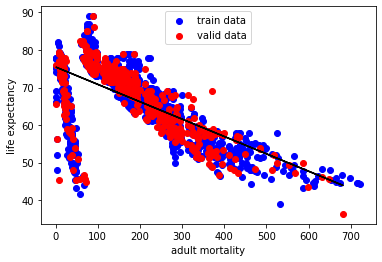

In [12]:
plt.scatter(X_train, y_train, color="b", label="train data")
plt.scatter(X_valid, y_valid, color="r", label="valid data")
plt.plot(X_valid, preds_valid, color="black")
plt.legend(loc=9)
plt.xlabel("adult mortality")
plt.ylabel("life expectancy")

plt.show()

In [13]:
# K-fold cross-validation
cv_model = LinearRegression()
am_variable = features.adult_mortality.values.reshape(-1, 1)

In [14]:
scores = -1 * cross_val_score(cv_model, am_variable, y,
                              cv=5,
                              scoring='neg_mean_squared_error')

print("Average MSE score:", scores.mean())

Average MSE score: 44.61328392677


## XGBoost

In [63]:
xgb_model = XGBRegressor(n_estimators=850, learning_rate=0.079)
xgb_model.fit(X_train, y_train,
              early_stopping_rounds=5,
              eval_set=[(X_valid, y_valid)],
              verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.079, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=850, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [64]:
xgb_preds_valid = xgb_model.predict(X_valid)
# print MSE
print(mean_squared_error(y_valid, xgb_preds_valid, squared=False))

5.424370441854262


In [65]:
print(r2_score(y_valid, xgb_preds_valid))

0.6369468978831363


In [66]:
print(xgb_model.score(X_valid, y_valid))

0.6369468978831363


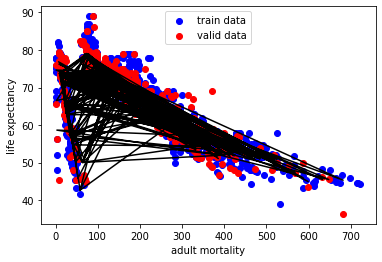

In [67]:
plt.scatter(X_train, y_train, color="b", label="train data")
plt.scatter(X_valid, y_valid, color="r", label="valid data")
plt.plot(X_valid, xgb_preds_valid, color="black")
plt.legend(loc=9)
plt.xlabel("adult mortality")
plt.ylabel("life expectancy")

plt.show()

## RANdom SAmple Consensus LR Model

In [59]:
# RANSAC model to deal with outliers
ransac_model = RANSACRegressor(LinearRegression(), 
                              max_trials=1000,
                              min_samples=449,
                              loss='squared_error',
                              residual_threshold=5.0,
                              random_state=0)
ransac_model.fit(X_train, y_train)

RANSACRegressor(base_estimator=LinearRegression(), loss='squared_error',
                max_trials=1000, min_samples=449, random_state=0,
                residual_threshold=5.0)

In [60]:
ransac_preds_valid = ransac_model.predict(X_valid)
# print MSE
print(mean_squared_error(y_valid, ransac_preds_valid, squared=False))

6.396386312930491


In [61]:
print(r2_score(y_valid, ransac_preds_valid))

0.49517501504701844


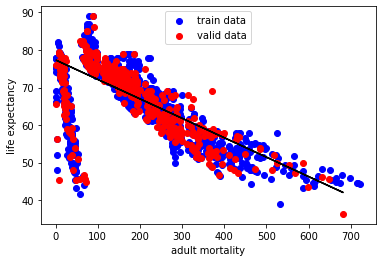

In [62]:
plt.scatter(X_train, y_train, color="b", label="train data")
plt.scatter(X_valid, y_valid, color="r", label="valid data")
plt.plot(X_valid, ransac_preds_valid, color="black")
plt.legend(loc=9)
plt.xlabel("adult mortality")
plt.ylabel("life expectancy")

plt.show()

## SGD Model

In [68]:
reg = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.001,
                                                   max_iter=1500, 
                                                   learning_rate='optimal',
                                                  loss='huber'))
reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.001, learning_rate='optimal',
                              loss='huber', max_iter=1500))])

In [69]:
gd_preds_valid = reg.predict(X_valid)

In [70]:
# print MSE
print(mean_squared_error(y_valid, gd_preds_valid, squared=False))

6.480961642953623


In [71]:
print(r2_score(y_valid, gd_preds_valid))

0.4817367995143249


In [26]:
# Grid search 
model = SGDRegressor(max_iter=1500)
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
sgd = GridSearchCV(model, param_grid)
sgd.fit(X_train, y_train)
print("Best score: " + str(sgd.best_score_))

Best score: 0.001825403788020785


In [27]:
print("SGD best params :", sgd.best_params_)

SGD best params : {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'elasticnet'}


In [28]:
# print MSE
print(mean_squared_error(y_valid, sgd.predict(X_valid), squared=False))

9.017781154771397


# Model inference

In [29]:
final_preds_test = ols_model.predict(test_data.adult_mortality.values.reshape(-1, 1))

In [33]:
# Dataframe of prediction outcome for each individual row in test data
output = pd.DataFrame({'AdultMortality': test_data.adult_mortality,
                       'Predicted LifeExpectancy': final_preds_test})

In [34]:
output

,AdultMortality,Predicted LifeExpectancy
0,268.0,63.060680
1,291.0,61.995651
2,316.0,60.838011
3,88.0,71.395688
4,91.0,71.256772
...,...,...
480,69.0,72.275495
481,336.0,59.911899
482,371.0,58.291203
483,527.0,51.067529
